<h1>Nezadovoljstvo putnika u zračnom prometu</h1>

<h2> 1. Ucitavanje potrebnih biblioteka </h2>

In [1]:

import pandas as pd 
import numpy as np 
import seaborn as sns
from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt 
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from itertools import product
from sklearn.model_selection import StratifiedKFold
import joblib
%matplotlib inline


<h2>2 Obrada podataka za treniranje modela</h2>

In [2]:
#ucitavanje vec podjeljenig train i test podataka
test = pd.read_csv('test.csv',sep=',') 
train = pd.read_csv('train.csv',sep=',')

print(f"Broj jedinki u train.csv: {len(train)} (80%)")
print(f"Broj jedinki u test.csv: {len(test)} (20%)")
print(f"ukupno postoji : {len(test)+len(train)} jedinstvenih jedinki")


Broj jedinki u train.csv: 103904 (80%)
Broj jedinki u test.csv: 25976 (20%)
ukupno postoji : 129880 jedinstvenih jedinki


In [3]:


#mjenjanja ne numerickih varijable u numericke
test['Gender']= test['Gender'].replace({'Male':0, 'Female':1})
test['Customer Type']= test['Customer Type'].replace({'Loyal Customer':0, 'disloyal Customer':1})
test['Type of Travel']= test['Type of Travel'].replace({'Personal Travel':0, 'Business travel':1})
test['Class']= test['Class'].replace({'Eco':0, 'Business':1, 'Eco Plus':2})
test['satisfaction']= test['satisfaction'].replace({'satisfied':0, 'neutral or dissatisfied':1})

train['Gender']= train['Gender'].replace({'Male':0, 'Female':1})
train['Customer Type']= train['Customer Type'].replace({'Loyal Customer':0, 'disloyal Customer':1})
train['Type of Travel']= train['Type of Travel'].replace({'Personal Travel':0, 'Business travel':1})
train['Class']= train['Class'].replace({'Eco':0, 'Business':1, 'Eco Plus':2})
train['satisfaction']= train['satisfaction'].replace({'satisfied':0, 'neutral or dissatisfied':1})



C:\Users\vboxuser\AppData\Local\Temp\ipykernel_8892\2382790850.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test['Gender']= test['Gender'].replace({'Male':0, 'Female':1})
C:\Users\vboxuser\AppData\Local\Temp\ipykernel_8892\2382790850.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test['Customer Type']= test['Customer Type'].replace({'Loyal Customer':0, 'disloyal Customer':1})
C:\Users\vboxuser\AppData\Local\Temp\ipykernel_8892\2382790850.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be r

In [4]:
train.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,0,0,13,0,2,460,3,4,...,5,4,3,4,4,5,5,25,18.0,1
1,1,5047,0,1,25,1,1,235,3,2,...,1,1,5,3,1,4,1,1,6.0,1
2,2,110028,1,0,26,1,1,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,0
3,3,24026,1,0,25,1,1,562,2,5,...,2,2,5,3,1,4,2,11,9.0,1
4,4,119299,0,0,61,1,1,214,3,3,...,3,3,4,4,3,3,3,0,0.0,0


In [5]:
# izbacivanje nepotrebnog prvog indexnog stupca te identifikatora osobe id 
train= train.drop(columns=['Unnamed: 0','id'])
test= test.drop(columns=['Unnamed: 0','id'])

In [6]:
test.head()
summary = pd.DataFrame({
    "Min": train.min(numeric_only=True), #provjera postoji li podataka sa vrijednosti 0 
    "Max": train.max(numeric_only=True)
})

print(summary)

                                    Min     Max
Gender                              0.0     1.0
Customer Type                       0.0     1.0
Age                                 7.0    85.0
Type of Travel                      0.0     1.0
Class                               0.0     2.0
Flight Distance                    31.0  4983.0
Inflight wifi service               0.0     5.0
Departure/Arrival time convenient   0.0     5.0
Ease of Online booking              0.0     5.0
Gate location                       0.0     5.0
Food and drink                      0.0     5.0
Online boarding                     0.0     5.0
Seat comfort                        0.0     5.0
Inflight entertainment              0.0     5.0
On-board service                    0.0     5.0
Leg room service                    0.0     5.0
Baggage handling                    1.0     5.0
Checkin service                     0.0     5.0
Inflight service                    0.0     5.0
Cleanliness                         0.0 

In [7]:
varijable = ["Age","Flight Distance", "Inflight wifi service", "Departure/Arrival time convenient", "Ease of Online booking", "Gate location", "Food and drink", "Online boarding", "Seat comfort", "Inflight entertainment", "On-board service", "Leg room service", "Baggage handling", "Checkin service", "Inflight service", "Cleanliness"]
 #0 u podacima se zamjenjuje sa vrijednosti nan u svrhu lakse uklanjanja ne postojecih podataka
train[varijable] = train[varijable].replace(0, np.nan)
train[varijable] = train[varijable].fillna(train[varijable].median())
test[varijable] = test[varijable].replace(0, np.nan)
test[varijable] = test[varijable].fillna(test[varijable].median())

In [8]:
print("NaN vrijednosti u train setu:", train.isna().sum().sum())
print("NaN vrijednosti u test setu:", test.isna().sum().sum())

NaN vrijednosti u train setu: 310
NaN vrijednosti u test setu: 83


In [9]:
test= test.dropna(how="any")#izbaciti sve redove gdje su sve varijable nan
train=train.dropna(how="any")


In [10]:
print("NaN vrijednosti u train setu:", train.isna().sum().sum())
print("NaN vrijednosti u test setu:", test.isna().sum().sum())

NaN vrijednosti u train setu: 0
NaN vrijednosti u test setu: 0


In [11]:

# === 1. SPOJ SVIH PODATAKA I ČIŠĆENJE ===
full_data = pd.concat([train, test], ignore_index=True)
full_data.columns = full_data.columns.str.strip()  # ukloni razmake iz naziva stupaca

# Lista kategorialnih varijabli
kategorialne_varijable = [
    "Gender", "Customer Type", "Type of Travel", "Class", "satisfaction",
    "Inflight wifi service", "Departure/Arrival time convenient", "Ease of Online booking",
    "Gate location", "Food and drink", "Online boarding", "Seat comfort",
    "Inflight entertainment", "On-board service", "Leg room service",
    "Baggage handling", "Checkin service", "Inflight service", "Cleanliness"
]

# Priprema tablice frekvencija
rows = []

for var in kategorialne_varijable:
    freqs = full_data[var].value_counts(dropna=False).sort_index()
    for val, count in freqs.items():
        rows.append({
            "Varijabla": var,
            "Vrijednost": val,
            "Broj jedinki": count
        })

# Pretvori u DataFrame i izvoz
tablica_raspodjela = pd.DataFrame(rows)
tablica_raspodjela = tablica_raspodjela.sort_values(by=["Varijabla", "Vrijednost"])
tablica_raspodjela.to_excel("raspodjele_kategorialne_tablica.xlsx", index=False)



In [12]:
# Lista numeričkih varijabli
varijable = [
    "Age", "Flight Distance", "Inflight wifi service", "Departure/Arrival time convenient",
    "Ease of Online booking", "Gate location", "Food and drink", "Online boarding", "Seat comfort",
    "Inflight entertainment", "On-board service", "Leg room service", "Baggage handling",
    "Checkin service", "Inflight service", "Cleanliness", "Departure Delay in Minutes",
    "Arrival Delay in Minutes"
]

# Izdvajanje numeričkih podataka
full_data_numeric = full_data[varijable]

# Izračun osnovnih statističkih mjera
statistika = full_data_numeric.describe().T
statistika = statistika[['mean', '50%', 'std']]
statistika.columns = ['Prosjek', 'Medijan', 'Standardna devijacija']
statistika = statistika.round(3)

# Ispis
print(statistika)



                                    Prosjek  Medijan  Standardna devijacija
Age                                  39.429     40.0                 15.118
Flight Distance                    1190.211    844.0                997.561
Inflight wifi service                 2.819      3.0                  1.239
Departure/Arrival time convenient     3.212      3.0                  1.351
Ease of Online booking                2.888      3.0                  1.272
Gate location                         2.977      3.0                  1.278
Food and drink                        3.208      3.0                  1.326
Online boarding                       3.348      4.0                  1.256
Seat comfort                          3.442      4.0                  1.319
Inflight entertainment                3.359      4.0                  1.334
On-board service                      3.383      4.0                  1.287
Leg room service                      3.369      4.0                  1.297
Baggage hand

In [13]:

X_train= train.iloc[:,:-1]#sve osim zadnjeg stupca se uzima u varijablu x
X_test= test.iloc[:,:-1]
y_train= train.iloc[:,-1]#samo zadnji stupac se uzima u varijablu y
y_test= test.iloc[:,-1]

# svi podaci podjeljeni u svrhu kasnije kross validacije
X = pd.concat([X_train, X_test], ignore_index=True)
y = pd.concat([y_train, y_test], ignore_index=True)

In [14]:
print(f"Broj jedinki u train.csv: {len(X_train)} (80%)")
print(f"Broj jedinki u test.csv: {len(X_test)} (20%)")
print(f"Ukupno postoji : {len(X_test)+len(X_train)} jedinstvenih jedinki")

Broj jedinki u train.csv: 103594 (80%)
Broj jedinki u test.csv: 25893 (20%)
Ukupno postoji : 129487 jedinstvenih jedinki


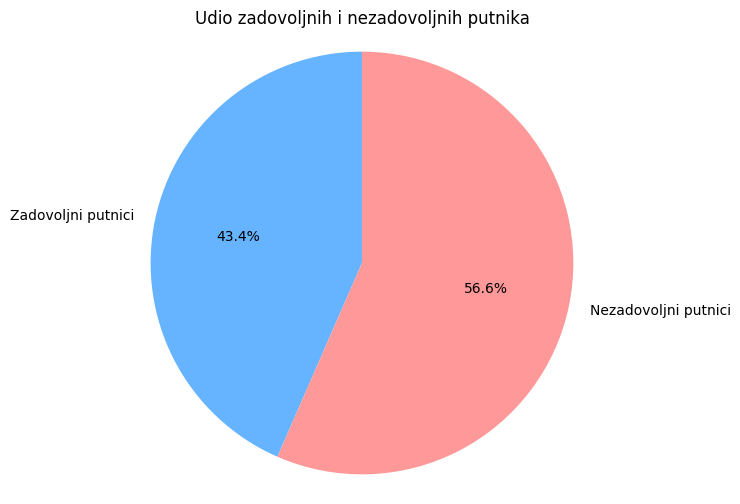

In [15]:

counts = y.value_counts().sort_index()  # 0 i 1 redom

labels = ['Zadovoljni putnici', 'Nezadovoljni putnici']
colors = ['#66b3ff', '#ff9999'] 

#pie chart zadovoljstva
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%.1f%%', startangle=90, colors=colors)
plt.title('Udio zadovoljnih i nezadovoljnih putnika')
plt.axis('equal')
plt.show()


<h2>3. Pronalazak optimalnih hiperparametara za modele </h2>

<h3>3.1. neuronska mreža</h3>

<b>Rezultat gridsearch za neuronske mreže dostupan u spremljenom formatu mlp_gridsearch_full.pkl. Ukloniti komentare i pokreniti kod samo u skučaaju želje za provjerom rezultata vrijeme izvođenja 10+ sati.</b>

In [16]:

#first_layer = [40, 75, 100, 130, 150]
#second_layer = [15, 30]
#third_layer = [10, 20, 30]

#hidden_layer_sizes_all = []

#for layer1 in first_layer:
#    hidden_layer_sizes_all.append((layer1,))

#for layer1 in first_layer:
#    for layer2 in second_layer:
#        hidden_layer_sizes_all.append((layer1, layer2))

#for layer1 in first_layer:
#    for layer2 in second_layer:
#        for layer3 in third_layer:
#            hidden_layer_sizes_all.append((layer1, layer2, layer3))

#param_grid_mlp = {
#    'hidden_layer_sizes': hidden_layer_sizes_all,
#    'activation': ['relu', 'tanh', 'logistic'],
#    'alpha': [0.0001, 0.001],
#    'solver': ['adam', 'sgd', 'lbfgs']
#}

#mlp = MLPClassifier(max_iter=300, random_state=0)
#cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

#grid_mlp = GridSearchCV(mlp, param_grid_mlp, cv=cv, scoring='accuracy', n_jobs=-1)
#grid_mlp.fit(X_train, y_train)

#print("najbolji hiperparametri za neuronske mrežu: ", grid_mlp.best_params_)
#print("Točnost (kros-validacija):", grid_mlp.best_score_)


#joblib.dump(grid_mlp, 'mlp_gridsearch_full.pkl') #ukloniti komentar ako se želi spremiti novi rezultati gridsearch



In [17]:

# Pretvori rezultate u DataFrame
grid_mlp = joblib.load("mlp_gridsearch_full.pkl")# komentirati ovu liniju ako je gridsearch ponovno napravljen
results_df = pd.DataFrame(grid_mlp.cv_results_)

# Ispiši najbolji rezultat
print("Najbolji hiperparametri za neuronsku mrežu:", grid_mlp.best_params_)
print(f"Točnost (kros-validacija): {grid_mlp.best_score_:.4f}")


Najbolji hiperparametri za neuronsku mrežu: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 15, 10), 'solver': 'adam'}
Točnost (kros-validacija): 0.9333


<h3>3.2. Stablo odlučivanja </h3>

In [18]:

param_grid_tree = {
    'max_depth': [5,10,15,20,25],
    'criterion': ['gini', 'entropy']
}

tree_model = DecisionTreeClassifier(random_state=0)
grid_tree = GridSearchCV(tree_model, param_grid_tree, cv=3, scoring='accuracy', n_jobs=-1)
grid_tree.fit(X_train, y_train)

print("najbolji hiperparametri za stablo odlučivanja:", grid_tree.best_params_)
print(" Točnost (kros-validacija):", grid_tree.best_score_)

najbolji hiperparametri za stablo odlučivanja: {'criterion': 'entropy', 'max_depth': 15}
 Točnost (kros-validacija): 0.9433944043253795


<h3>3.3. Nasumična šuma</h3>

In [19]:

param_grid_rf = {
    'n_estimators': [50,75,100,150,200],
    'max_depth': [5,10,15,20],
    'max_features': ['sqrt', 'log2']
    
}

rf_model = RandomForestClassifier(random_state=0)
grid_rf = GridSearchCV(rf_model, param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("najbolji hiperparametri za nasumičnu šumu:", grid_rf.best_params_)
print(" Točnost (kros-valudacija):", grid_rf.best_score_)

najbolji hiperparametri za nasumičnu šumu: {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 200}
 Točnost (kros-valudacija): 0.9541093276481721


<h2>4. Treniranje modela </h2>

<h3>4.1. model neuronske mreže klasifikacije</h3>

In [20]:

nn_class= MLPClassifier(solver='adam', hidden_layer_sizes=(100,15,10), alpha=0.0001, activation='relu',random_state=0, max_iter=300)
nn_class.fit(X_train,y_train)




print(nn_class.predict(X_test))

nn_class_train_acu= nn_class.score(X_train,y_train)
nn_class_test_acu= nn_class.score(X_test,y_test)

print(f'Koeficijent determinacije na skupu za testiranje: {nn_class_test_acu:.3f}')

print(f'tocnost na  podacima za treniranje: {nn_class_train_acu:.3f}')
print(f'razlika izmedu predikcija podataka za treniranje i testiranje je {(nn_class_train_acu-nn_class_test_acu)*100:.3f}%')

print('Kros-validacijska točnost (5-fold): 0.9395 +/- 0.0026')#u svrhu brzeg izvodenja u slučaju drugih hiperparametara rezultat se moze promjeniti 


#kros-validacija ukloniti komentare samo ako se zele provjerit rezultati 15-20 minuta vremena izvodenja

#nn_class_cv = MLPClassifier(solver='adam', hidden_layer_sizes=(100,15,10), alpha=0.0001, activation='relu',random_state=0, max_iter=300) # Povećan max_iter, uklonjen early_stopping
#nn_cv_score= cross_val_score(nn_class_cv, X,y, cv=5, scoring='accuracy',n_jobs=-1)
#print(f"Kros-validacijska točnost (5-fold): {nn_cv_score.mean():.4f} +/- {nn_cv_score.std():.4f}")

[0 0 1 ... 1 0 1]
Koeficijent determinacije na skupu za testiranje: 0.940
tocnost na  podacima za treniranje: 0.945
razlika izmedu predikcija podataka za treniranje i testiranje je 0.455%
Kros-validacijska točnost (5-fold): 0.9395 +/- 0.0026


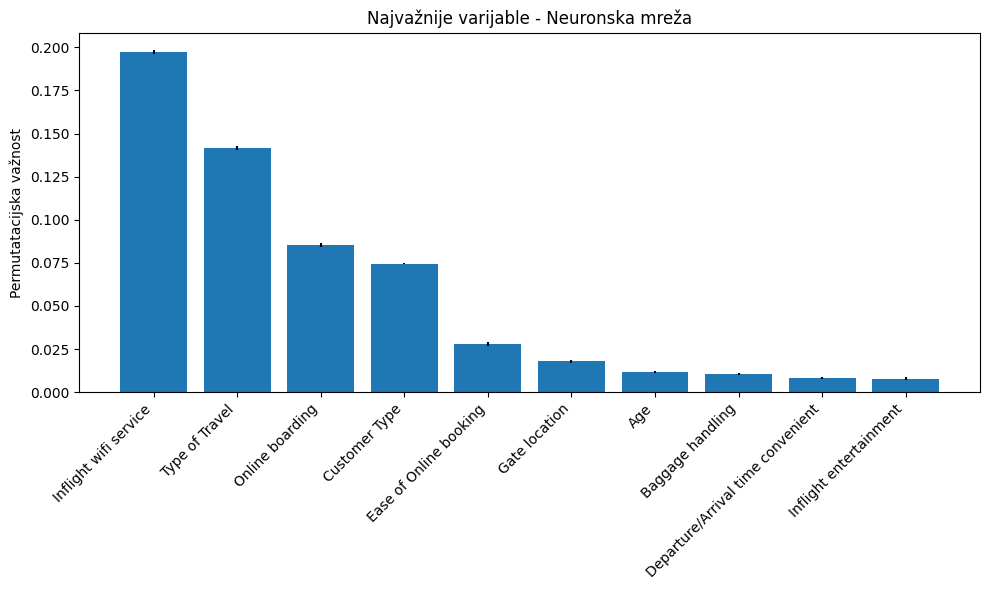

In [21]:
# Izračunaj permutation importance
result = permutation_importance(nn_class, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1)

# Dobij srednje vrijednosti važnosti i sort
importances = result.importances_mean
std = result.importances_std
indices = np.argsort(importances)[::-1]

# Ako X_test ima imena stupaca (npr. ako je pandas DataFrame)
feature_names = X_test.columns if hasattr(X_test, 'columns') else [f"Feature {i}" for i in range(X_test.shape[1])]
plt.figure(figsize=(10, 6))
plt.bar(range(10), importances[indices[:10]], yerr=std[indices[:10]], align="center")
plt.xticks(range(10), [feature_names[i] for i in indices[:10]], rotation=45, ha='right')
plt.ylabel("Permutatacijska važnost")
plt.title("Najvažnije varijable - Neuronska mreža")
plt.tight_layout()
plt.show()

<b>krivulja ucenja spremljena kao Krivulja_NN.png. U svrhu provjere rezultata ukloniti komentare u sljedečem kodu vrijeme trajanja 10-14 min </b>

In [22]:

#model_nn = MLPClassifier(solver='adam', hidden_layer_sizes=(100,15,10), alpha=0.0001, activation='relu',random_state=0, max_iter=300)

#train_sizes_nn, train_scores_nn, test_scores_nn = learning_curve(
#    model_nn, X, y, cv=5, scoring='accuracy', n_jobs=-1,
#    train_sizes=np.linspace(0.1, 1.0, 5), shuffle=True, random_state=0
#)

# Izračunaj srednje vrijednosti
#train_mean = train_scores_nn.mean(axis=1)
#test_mean = test_scores_nn.mean(axis=1)

# Crtanje grafa
#plt.figure(figsize=(8, 6))
#plt.plot(train_sizes_nn, train_mean, 'o-', color='r', label='Točnost na podacima za treniranje')
#plt.plot(train_sizes_nn, test_mean, 'o-', color='g', label='Validacijska točnost')
#plt.title('Krivulja učenja – Neuronska mreža')
#plt.xlabel('Broj uzoraka za treniranje')
#plt.ylabel('Točnost')
#plt.grid(True)
#plt.legend(loc='best')
#plt.tight_layout()

 #Spremanje grafa
#plt.savefig("Krivulja_NN.png", dpi=300)  # Možeš promijeniti ime i lokaciju
#plt.close()  # Važno ako koristiš više grafova u petlji

<h3>4.2. Model stabla odlučivanja</h3>

In [23]:


clf = tree.DecisionTreeClassifier(max_depth=11, random_state=0)
clf = clf.fit(X_train, y_train)

clf_for_cv = tree.DecisionTreeClassifier(max_depth=11, random_state=0)
scores_clf_cv = cross_val_score(clf_for_cv, X, y, cv=5, scoring='accuracy', n_jobs=-1)

print(clf.predict(X_test))

train_tree_acu= clf.score(X_train,y_train)
test_tree_acu=clf.score(X_test,y_test)

print(f'Koeficijent determinacije na skupu za testiranje: {test_tree_acu:.3f}')

print(f'tocnost na  podacima za treniranje: {train_tree_acu:.3f}')
print(f'razlika izmedu predikcija podataka za treniranje i testiranje je {(train_tree_acu-test_tree_acu)*100:.3f}%')
print(f"Kros-validacijska točnost (5-fold): {scores_clf_cv.mean():.4f} +/- {scores_clf_cv.std():.4f}")






[0 0 1 ... 1 0 1]
Koeficijent determinacije na skupu za testiranje: 0.941
tocnost na  podacima za treniranje: 0.951
razlika izmedu predikcija podataka za treniranje i testiranje je 0.940%
Kros-validacijska točnost (5-fold): 0.9417 +/- 0.0021


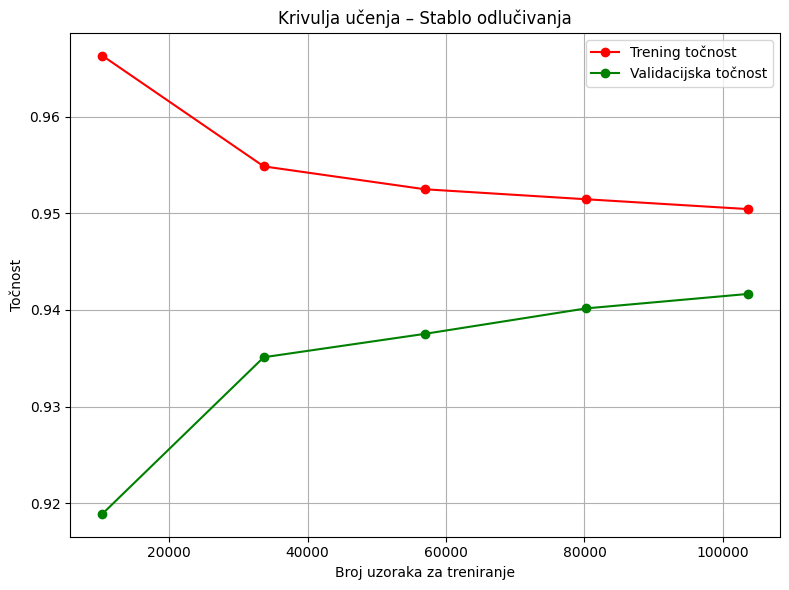

In [24]:
train_sizes_tree, train_scores_tree, test_scores_tree = learning_curve(
    clf, X, y, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), shuffle=True, random_state=0
)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes_tree, train_scores_tree.mean(axis=1), 'o-', color="r", label="Trening točnost")
plt.plot(train_sizes_tree, test_scores_tree.mean(axis=1), 'o-', color="g", label="Validacijska točnost")
plt.title("Krivulja učenja – Stablo odlučivanja")
plt.xlabel("Broj uzoraka za treniranje")
plt.ylabel("Točnost")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()



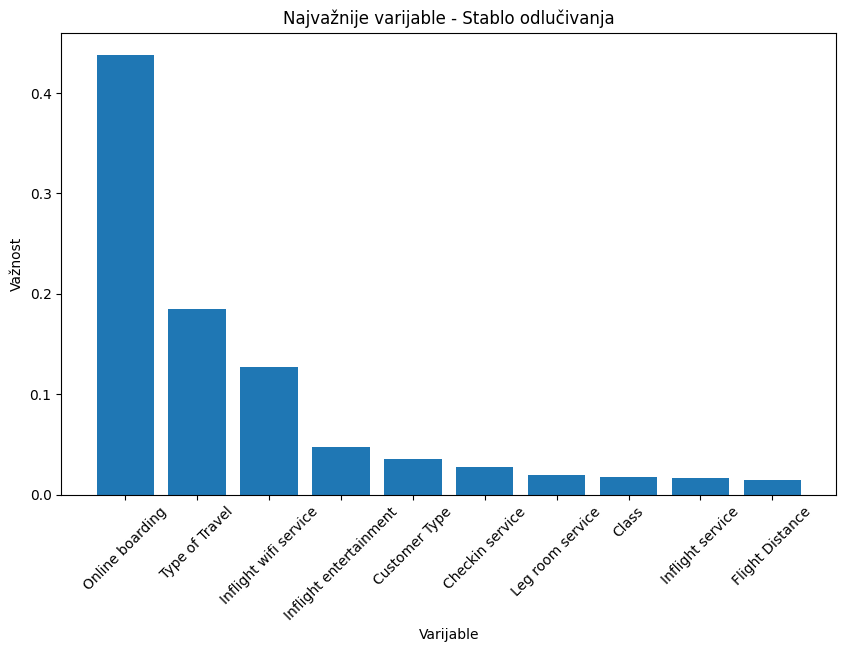

In [25]:


# Dohvati važne značajke
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]  # Sortiraj po važnosti

# Prikaz top 10 značajki
plt.figure(figsize=(10, 6))
plt.title("Najvažnije varijable - Stablo odlučivanja")
plt.bar(range(10), importances[indices[:10]], align="center")
plt.xticks(range(10), X_train.columns[indices[:10]], rotation=45)
plt.xlabel("Varijable")
plt.ylabel("Važnost")
plt.show()

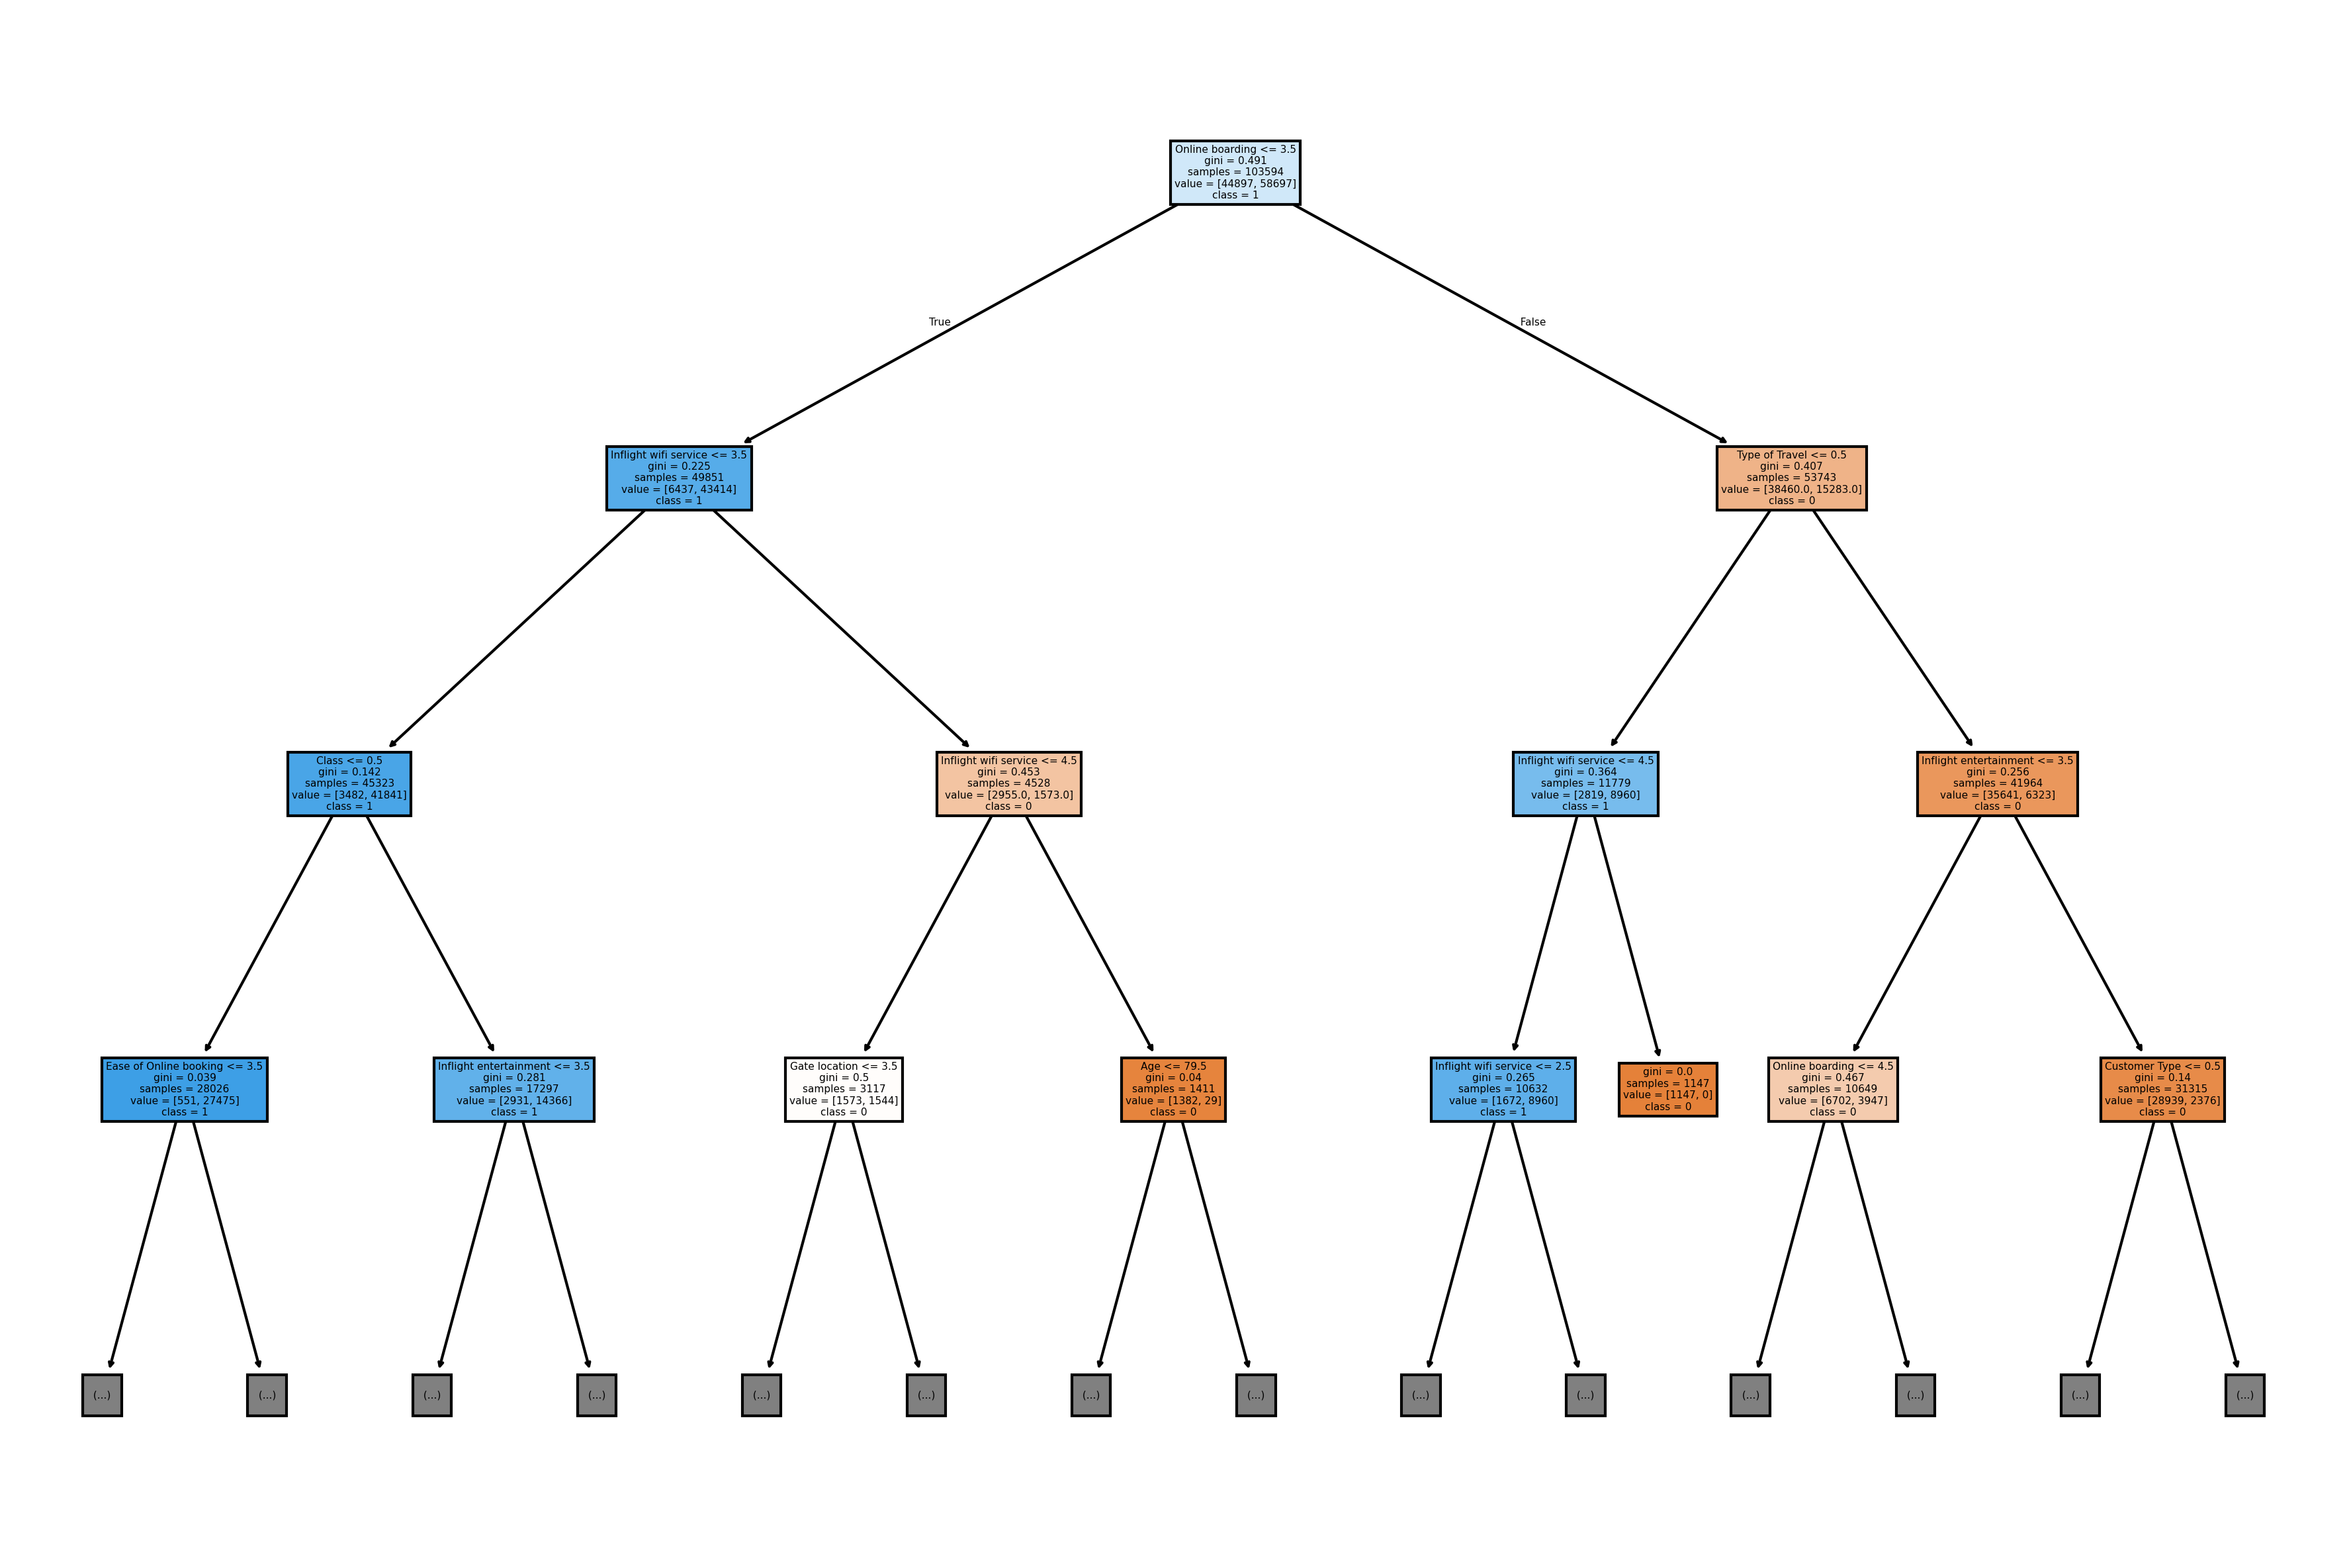

In [26]:
plt.figure(figsize=(15, 10), dpi=300)  # Povećan DPI za bolju čitljivost
plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=["0", "1"], max_depth=3)
plt.show()

<h3>4.3. Model nasumične šume</h3>

In [27]:

rf = RandomForestClassifier(n_estimators=200, random_state=0, max_depth=12)
rf = rf.fit(X_train,y_train)
y_pred=(rf.predict(X_test))

rf_train_acu= rf.score(X_train,y_train)
rf_test_acu= rf.score(X_test,y_test)
scores_rf_cv = cross_val_score(RandomForestClassifier(n_estimators=200, random_state=0, max_depth=12), X, y, cv=5, scoring='accuracy')


print(f'Koeficijent determinacije na skupu za testiranje: {rf_test_acu:.3f}')

print(f'tocnost na  podacima za treniranje: {rf_train_acu:.3f}')
print(f'razlika izmedu predikcija podataka za treniranje i testiranje je {(rf_train_acu-rf_test_acu)*100:.3f}%')
print(f"Kros-validacijska točnost (5-fold) s max_depth=12: {scores_rf_cv.mean():.4f} +/- {scores_rf_cv.std():.4f}")





Koeficijent determinacije na skupu za testiranje: 0.945
tocnost na  podacima za treniranje: 0.954
razlika izmedu predikcija podataka za treniranje i testiranje je 0.935%
Kros-validacijska točnost (5-fold) s max_depth=12: 0.9445 +/- 0.0015


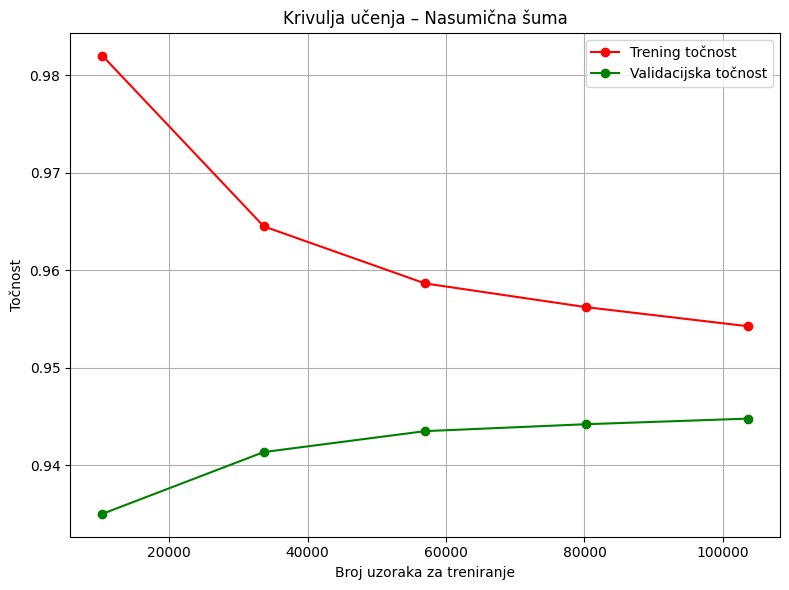

In [28]:
# Nasumična šuma
model_rf = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=0)

train_sizes_rf, train_scores_rf, test_scores_rf = learning_curve(
    model_rf, X, y, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), shuffle=True, random_state=0
)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes_rf, train_scores_rf.mean(axis=1), 'o-', color="r", label="Trening točnost")
plt.plot(train_sizes_rf, test_scores_rf.mean(axis=1), 'o-', color="g", label="Validacijska točnost")
plt.title("Krivulja učenja – Nasumična šuma")
plt.xlabel("Broj uzoraka za treniranje")
plt.ylabel("Točnost")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

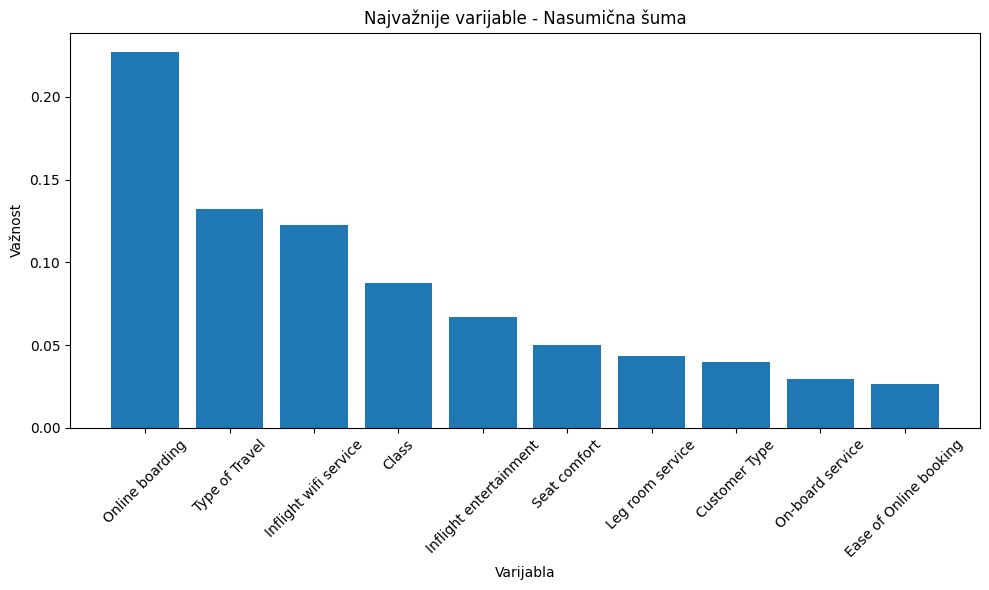

In [29]:
importances_rf = rf.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Najvažnije varijable - Nasumična šuma")
plt.bar(range(10), importances_rf[indices_rf[:10]], align="center")
plt.xticks(range(10), X_train.columns[indices_rf[:10]], rotation=45)
plt.xlabel("Varijabla")
plt.ylabel("Važnost")
plt.tight_layout()
plt.show()

<h2>5. Usporedba performansi modela </h2>

In [30]:


print('neuronska mreža klasifikacija')
matrica_konfuzije = pd.crosstab(nn_class.predict(X_test), y_test.values)
print(matrica_konfuzije)
print(f'Koeficijent determinacije na skupu za testiranje: {nn_class_test_acu:.3f}')
print('Kros-validacijska točnost (5-fold): 0.9395 +/- 0.0026')
#print(f"Kros-validacijska točnost (5-fold): {nn_cv_score.mean():.4f} +/- {nn_cv_score.std():.4f}")  # samo u slucaju ako je krosvalidacija testirana ukloniti komentar
print('Stopa odaziva za neuronsku mrežu: {:.2f}'.format(recall_score(y_test, nn_class.predict(X_test))))
print('Preciznost za neuronsku mrežu: {:.2f}'.format(precision_score(y_test, nn_class.predict(X_test))))
print('F1-score za neuronsku mrežu: {:.2f}'.format(f1_score(y_test, nn_class.predict(X_test), pos_label=1)))

print('------------------------------------------------------------------------------------------------------------')
print('\n')
print('stablo odlucivanja')
matrica_konfuzije2 = pd.crosstab(clf.predict(X_test), y_test.values)
print(matrica_konfuzije2)
print(f'Koeficijent determinacije na skupu za testiranje: {test_tree_acu:.3f}')
print(f"Kros-validacijska točnost (5-fold): {scores_clf_cv.mean():.4f} +/- {scores_clf_cv.std():.4f}")
print('Stopa odaziva za stablo odlučivanja: {:.2f}'.format(recall_score(y_test, clf.predict(X_test))))
print('Preciznost za stablo odlučivanja: {:.2f}'.format(precision_score(y_test, clf.predict(X_test))))
print('F1-score za stablo odlučivanja: {:.2f}'.format(f1_score(y_test, clf.predict(X_test), pos_label=1)))
print('------------------------------------------------------------------------------------------------------------')

print('\n')
print('Nasumicna suma')
matrica_konfuzije3 = pd.crosstab(rf.predict(X_test), y_test.values)
print(matrica_konfuzije3)
print(f'Koeficijent determinacije na skupu za testiranje: {rf_test_acu:.3f}')
print(f"Kros-validacijska točnost (5-fold): {scores_rf_cv.mean():.4f} +/- {scores_rf_cv.std():.4f}")
print('Stopa odaziva za nasumicnu sumu: {:.2f}'.format(recall_score(y_test, rf.predict(X_test))))
print('Preciznost za nasumicnu sumu: {:.2f}'.format(precision_score(y_test, rf.predict(X_test))))
print('F1-score za nasumičnu šumu: {:.2f}'.format(f1_score(y_test, rf.predict(X_test), pos_label=1)))



neuronska mreža klasifikacija
col_0      0      1
row_0              
0      10384    568
1        981  13960
Koeficijent determinacije na skupu za testiranje: 0.940
Kros-validacijska točnost (5-fold): 0.9395 +/- 0.0026
Stopa odaziva za neuronsku mrežu: 0.96
Preciznost za neuronsku mrežu: 0.93
F1-score za neuronsku mrežu: 0.95
------------------------------------------------------------------------------------------------------------


stablo odlucivanja
col_0      0      1
row_0              
0      10452    610
1        913  13918
Koeficijent determinacije na skupu za testiranje: 0.941
Kros-validacijska točnost (5-fold): 0.9417 +/- 0.0021
Stopa odaziva za stablo odlučivanja: 0.96
Preciznost za stablo odlučivanja: 0.94
F1-score za stablo odlučivanja: 0.95
------------------------------------------------------------------------------------------------------------


Nasumicna suma
col_0      0      1
row_0              
0      10480    537
1        885  13991
Koeficijent determinacije n

<h2>6. Heatmap utjecaja varijabli na modele </h2>

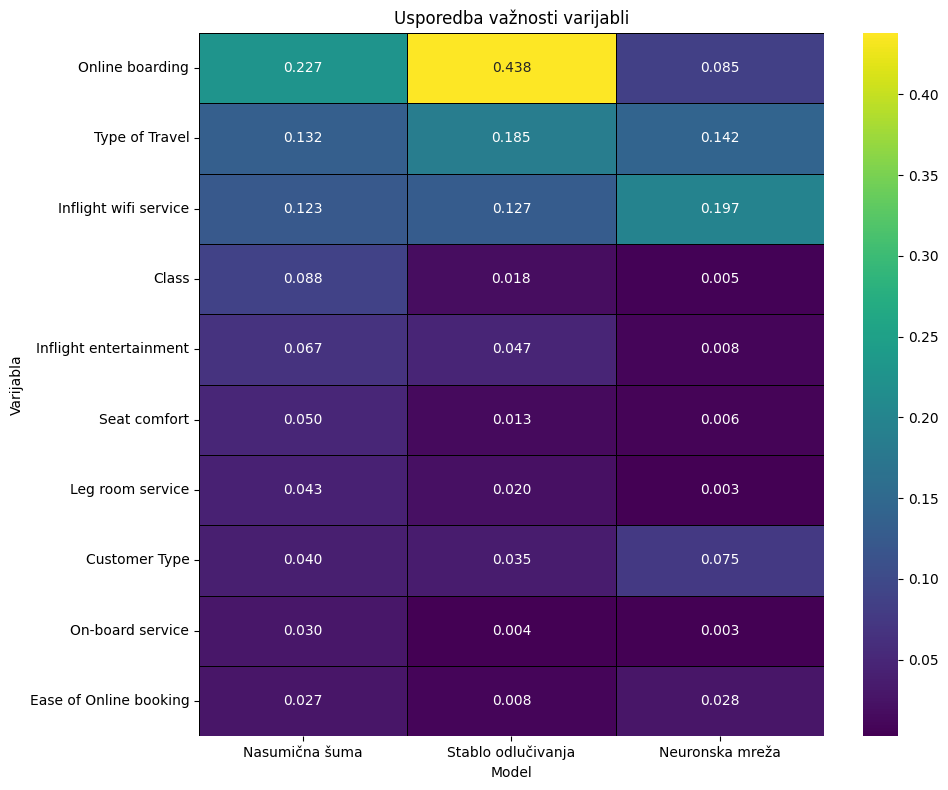

In [31]:
# --- RF i DT: već imaju .feature_importances_ ---
rf_importances_series = pd.Series(rf.feature_importances_, index=X_train.columns)
dt_importances_series = pd.Series(clf.feature_importances_, index=X_train.columns)

# --- NN: koristi permutation importance ---
result_nn = permutation_importance(nn_class, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1)
nn_importances_series = pd.Series(result_nn.importances_mean, index=X_test.columns)

# --- Top 10 značajki po Random Forestu ---
top_n = 10
top_features = rf_importances_series.nlargest(top_n).index

# --- Kombiniraj u DataFrame ---
comparison_importances = pd.DataFrame({
    'Nasumična šuma': rf_importances_series.reindex(top_features),
    'Stablo odlučivanja': dt_importances_series.reindex(top_features),
    'Neuronska mreža': nn_importances_series.reindex(top_features)
})

comparison_importances.fillna(0, inplace=True)
comparison_importances.sort_values(by='Nasumična šuma', ascending=False, inplace=True)

# --- Prikaz heatmape ---
plt.figure(figsize=(10, 8))
sns.heatmap(comparison_importances, annot=True, cmap='viridis', fmt=".3f", linewidths=.5, linecolor='black')
plt.title(f'Usporedba važnosti varijabli')
plt.xlabel('Model')
plt.ylabel('Varijabla')
plt.tight_layout()
plt.show()